In [92]:
# !pip install tqdm==4.28.1
# !pip install -U gast==0.2.2
# !pip install gdown

# !gdown https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
# !mkdir datasets
# !tar -C datasets -xzf airport-alunos.tgz


In [1]:
import random

#%tensorflow_version 2.x
import tensorflow as tf; print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


from sklearn.datasets import load_sample_image;
from sklearn.manifold import TSNE


import seaborn as sns


import numpy as np
import tqdm; print(tqdm.__version__)
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline


2.0.0
4.28.1


In [2]:
def scatter(x, labels, subtitle='None'):
    # We choose a color palette with seaborn.
    palette_size = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", palette_size))
    
    color_map = dict({})
    color_count = 0
    for l in labels:
        if l not in color_map:
            color_map[l] = color_count
            color_count = color_count + 1
    
    def get_color_idx(label):
        return color_map[label]
        
    def get_colores_idx(labels_):
        return np.array([get_color_idx(l) for l in labels_])
        
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[get_colores_idx(labels)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for l, i in zip(labels, range(len(labels))):
        # Position of each label.
        xtext, ytext = np.median(x[labels == l, :], axis=0)
        txt = ax.text(xtext, ytext, labels[i], fontsize=16, 
                      color = palette[get_color_idx(l)]) #, bbox=dict(alpha=0.5))
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="yellow"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [3]:
def create_base_model(input_shape):
    input_layer = Input(shape = input_shape)
    
    model = Conv2D(8, (3, 3), activation = None, padding='same')(input_layer)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(16, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(32, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(64, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Flatten()(model)
    model = Dense(64, activation='relu')(model)
    
    model = Model(inputs=input_layer, outputs=model)
    
    return model

### Defining S1 with TripletLoss

In [4]:
class TripletLossLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(TripletLossLayer, self).__init__()
    
    def euclidean_distance(self, vects):
        x, y = vects
        x = tf.cast(x, 'float32')
        y = tf.cast(y, 'float32')

        return K.mean(K.sum(K.square(x-y),axis=1))
    
    def call(self, inputs=None):
        #     Calcule triplet loss 
        #     loss = max(dist(a, p) - dist(a, n) + margin, 0)
        self.margin = tf.constant(0.4 , dtype='float32')
        a, p, n = inputs
        a = tf.cast(a, 'float32')
        p = tf.cast(p, 'float32')
        n = tf.cast(n, 'float32')
        
        # Calcule triplet loss 
        subt_ = tf.subtract(self.euclidean_distance([a, p]) , self.euclidean_distance([a, n]))
        sum_ = tf.add(subt_, self.margin)
        
        loss = K.maximum(sum_, 0.0)
        # add in model loss
        self.add_loss(loss)
    
        return a

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 64)           156144      input_2[0][0]                    
                                                                 input_3[0][0]              

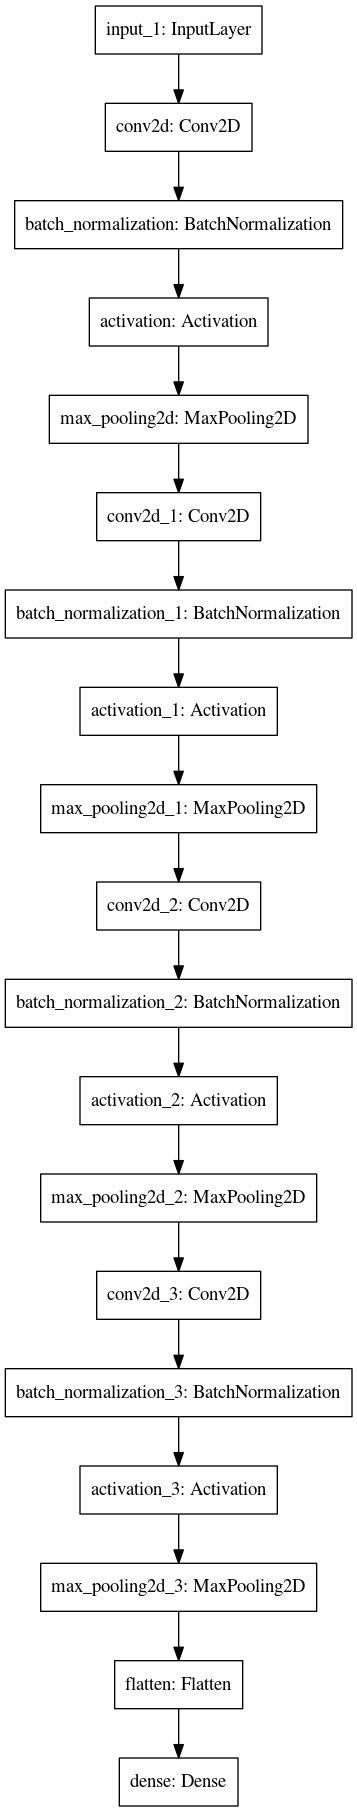

In [5]:
# input_shape = (28, 28, 1)
input_shape = (128, 64, 3)
base_network = create_base_model(input_shape)

input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

processed_a = base_network(input_anchor)
processed_p = base_network(input_positive)
processed_n = base_network(input_negative)

# loss = Lambda(triplet_loss)([processed_a, processed_p, processed_n])
loss_layer = TripletLossLayer()([processed_a, processed_p, processed_n])

model = Model([input_anchor, input_positive, input_negative], loss_layer)
model.compile(loss=(lambda y_true, ypred: 0.0))

embs_model = base_network
embs_model.compile(loss=(lambda y_true, ypred: 0.0))

model.summary()
tf.keras.utils.plot_model(model)

## Experiments with MNIST

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float')

### Show TSNE Before Training

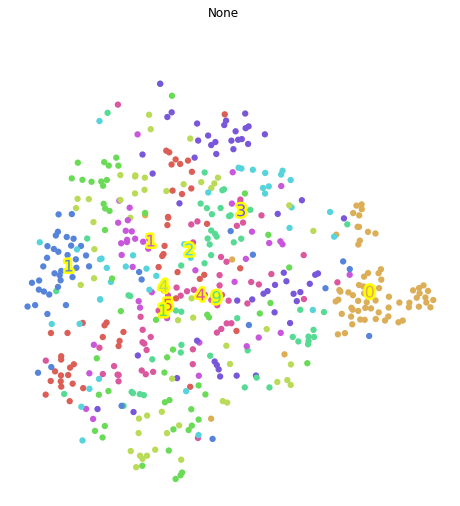

In [10]:
embs = embs_model.predict(x_train[:512])
labels = y_train[:512]
embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels)

In [17]:
def create_triplets(num_batches, batch_size):
    for _ in range(num_batches):
#     while True:
        batch = []
        clazz = []
        for _ in range(batch_size):
            grps_number = [1, 2, 3, 4, 5 ,6, 7, 8, 9, 0]
            
            grp = random.choice(grps_number)
            grps_number.remove(grp)
            img_a = x_train[y_train==grp][np.random.randint(x_train[y_train==grp].shape[0])]
            img_p = x_train[y_train==grp][np.random.randint(x_train[y_train==grp].shape[0])]
            
            grp_2 = random.choice(grps_number)
            img_n = x_train[y_train==grp_2][np.random.randint(x_train[y_train==grp_2].shape[0])]
            
            batch.append([img_a, img_p, img_n])
        out = np.array(batch)
        yield [out[:, i] for i in range(3)]

In [24]:
for inp_ in create_triplets(3000, 4):
    print(np.array(inp_).shape)
    break

(3, 4, 28, 28, 1)


In [23]:
print(np.array(X_train).shape)

(512, 3, 128, 64, 3)


In [12]:
batch_size = 64
y_true = np.array([[0.0 for _ in range(64)] for _ in range(batch_size)])


early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0,
                                                         verbose=0, restore_best_weights=True)

for inp_ in create_triplets(3000, batch_size):
    model.fit(inp_ , y_true, batch_size=5, epochs=1000000, callbacks=[early_stopping], shuffle=True, validation_split=0.5)

Train on 32 samples, validate on 32 samples
Epoch 1/1000000
32/32 [==============================] - 8s 249ms/sample - loss: 0.7618 - val_loss: 0.0376
Epoch 2/1000000
32/32 [==============================] - 0s 7ms/sample - loss: 0.0000e+00 - val_loss: 0.0555
Epoch 3/1000000
32/32 [==============================] - 0s 5ms/sample - loss: 0.0000e+00 - val_loss: 0.0522
Epoch 4/1000000
32/32 [==============================] - 0s 4ms/sample - loss: 0.3959 - val_loss: 0.0000e+00
Epoch 5/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/1000000
32/32 [==============================] - 0s 4ms/sample

KeyboardInterrupt: 

### Show TSNE After Training

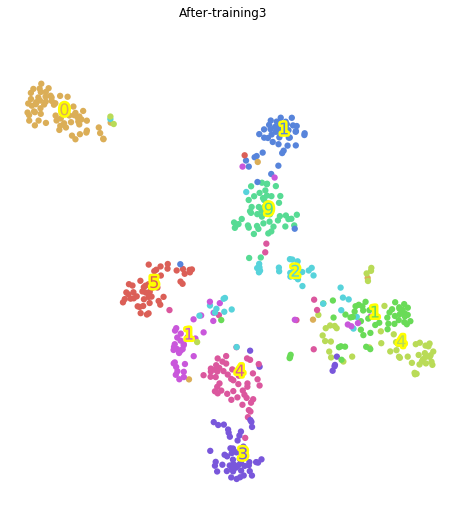

In [13]:
embs = embs_model.predict(x_train[:512])
labels = y_train[:512]
embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels, subtitle="After-training3")

## Experiments With Real Dataset

In [11]:
from tripplet_data import data_generator

X_train, Y_train = data_generator('datasets/airport-alunos/treino/', 512)
X_val, Y_val = data_generator('datasets/airport-alunos/val/', 64)

(3, 512, 128, 64, 3)
(512, 2)
(3, 64, 128, 64, 3)
(64, 2)


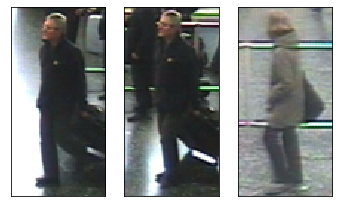

In [20]:
print(np.array(X_train).shape)
print(Y_train.shape)
print(np.array(X_val).shape)
print(Y_val.shape)

from dataset_utils import show_side_by_side
show_side_by_side(np.array([X_train[i][0] for i in range(3)]))

### Show TSNE Before Training

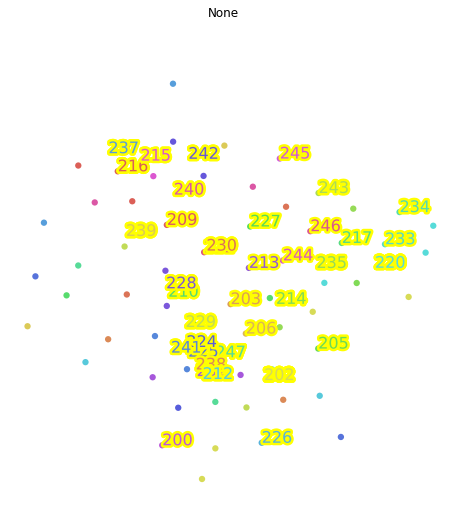

In [13]:
embs = embs_model.predict(X_val)
labels = Y_val[:, 0].astype(int)

embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels)

In [25]:
y_true = np.array([[0.0 for _ in range(64)] for _ in range(np.array(X_train).shape[1])])
y_true_val = np.array([[0.0 for _ in range(64)] for _ in range(np.array(X_val).shape[1])])

early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0,
                                                         verbose=0, restore_best_weights=True)

model.fit(X_train, y_true, batch_size=16, epochs=20000000 , shuffle=True, callbacks=[early_stopping],
          validation_data=[X_val, y_true_val])

Train on 512 samples, validate on 64 samples
Epoch 1/20000000
512/512 [==============================] - 6s 11ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
512/512 [==============================] - 6s 11ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
512/512 [==============================] - 6s 11ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
512/512 [==============================] - 6s 12ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
512/512 [==============================] - 6s 12ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
512/512 [==============================] - 6s 13ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00


### Show TSNE After Training

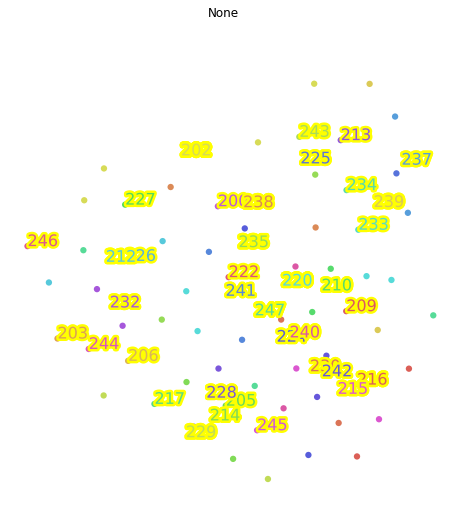

In [26]:
embs = embs_model.predict(X_val)
labels = Y_val[:, 0].astype(int)

embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels)